In [7]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten #, Reshape
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D

%run profplot.py

# Useful Functions

In [8]:
def Show_weights(model,l=0,label="model"):
    c=['r','y','c','b','m'] #colori
    m=['o','s','D','<','>'] #markers
    ms=10
    
    w = model.layers[l].get_weights()[0]
    wT=w.T
    M=len(wT)
    b = model.layers[l].get_weights()[1]
    
    fig,AX=plt.subplots(1,2,figsize=(12,4.4))
    ax=AX[0]
    ax.axhline(0, c="k")
    ax.plot((0,))
    for i in range(M):
        ax.plot(wT[i][0],"-",c=c[i],marker=m[i],label=str(i),markersize=ms)
    ax.set_title(label+': filters of layer '+str(l))
    ax.set_xlabel('index')
    ax=AX[1]
    ax.axhline(0, c="k")
    for i in range(M):
        ax.plot((i),(b[i]),c=c[i],marker=m[i],label="filter "+str(i),markersize=ms)
    ax.set_title(label+': bias of layer '+str(l))
    ax.set_xlabel('filter nr')
    ax.set_xticks(np.arange(5))
    ax.legend()
    plt.show()
def Show_history(fit):
    fig,AX=plt.subplots(1,2,figsize=(12,5.))
    ax=AX[0]
    ax.plot(fit.history['accuracy'],"b",label="train")
    ax.plot(fit.history['val_accuracy'],"r--",label="valid.")
    ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray",label="random choice")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0, 1])
    ax.legend()
    ax=AX[1]
    ax.plot(fit.history['loss'],"b",label="train")
    ax.plot(fit.history['val_loss'],"r--",label="valid.")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.set_ylim([0, 1.05*np.max(fit.history['loss'])])
    ax.legend()
    plt.show()
    
def build_model(init='normal', reg='l2', lmb=0.2):
    #Initializers
    if init=='zeros':
        ini=tf.keras.initializers.Zeros()
    elif init=='ones':
        ini=tf.keras.initializers.Ones()
    elif init=='normal':
        ini=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
    else:
        print('Error Initializers')
    #Regularizers
    if reg=='l1':
        rer=tf.keras.regularizers.l1(lmb)
    elif reg=='l2':
        reg=tf.keras.regularizers.l2(lmb)
    elif reg=='l1_l2':
        reg=tf.keras.regularizers.l1_l2(lmb, lmb)
    else:
        print('Error Regularizers')
    # challenge: at most 600 tunable parameters
    model = Sequential()
    model.add(Conv1D(filters=5, kernel_size=11, 
                     kernel_initializer=ini, # ini - ini_0 - ini_1
                     kernel_regularizer=reg,
                     activation='relu', 
                     input_shape=input_shape))
    model.add(AveragePooling1D(5))
    model.add(Conv1D(filters=5, kernel_size=7, 
                     activation='relu'))
    model.add(Flatten())
    model.add(Dense(12, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n_class, activation='softmax')) # softmax !    --->n_class=3 : Multiclassification
    opt = tf.keras.optimizers.Adam()
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt,metrics=['accuracy'])
    return model

### Read data

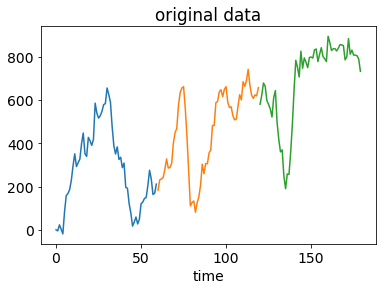

data:  10000


In [9]:
str0 = 'ts_L60_Z12_A500_DX50_bias5_N10000.dat'
fnamex='DATA/x_'+str0
fnamey='DATA/y_'+str0
x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
N,L = len(x), len(x[0]) #10000 60
Show_data(x,L,"original data")
categ = np.loadtxt(fnamey, dtype=int)
n_class = 3    # y.argmax() - y.argmin() +1
print('data: ',N)
y = np.zeros((N,n_class))
for i in range(N):
    y[i][categ[i]] = 1.


### Rescale data, split train/val.

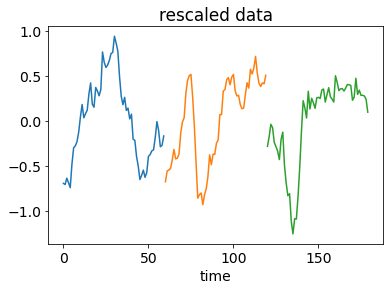

N_train= 8000   N_val= 2000   L= 60   n_class= 3


In [11]:
#OPTIOIN 1----- 
xm = x.mean(axis=1)
for i in range(N):
    x[i] = x[i]-xm[i]
x_scaled = x/400
Show_data(x_scaled,L,"rescaled data") 

perc_train=0.8
N_train = int(perc_train*N)
x_train = x_scaled[:N_train]
y_train = y[:N_train]
x_val = x_scaled[N_train:]
y_val = y[N_train:]
N_val = len(x_val)
print('N_train=',N_train,'  N_val=',N_val,'  L=',L,'  n_class=',n_class)
# Keras wants an additional dimension with a 1 at the end
x_train = x_train.reshape(x_train.shape[0], L, 1) #shape: (8000,60,1 aggiuntiva)
x_val =  x_val.reshape(x_val.shape[0], L, 1) #shape: (2000,60,1 aggiuntiva)
input_shape = (L, 1)

## GridSearch

In [12]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
BATCH_SIZE = 250
EPOCHS = 50
parameters = {
                'reg':['l1', 'l2', 'l1_l2'],
                'lmb':[0, 1e-1, 1e-3, 1e-5]
             }

model_gridsearch = KerasClassifier(build_fn = build_model, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)
grid = GridSearchCV(estimator=model_gridsearch, param_grid=parameters, n_jobs=1, cv=4)
grid_result = grid.fit(x_train,y_train)

ModuleNotFoundError: No module named 'sklearn'

In [6]:
# summarize results
print("\n\nBest: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
      print("%f (%f) with: %r" % (mean, stdev, param))



Best: 0.972625 using {'lmb': 1e-05, 'reg': 'l1_l2'}
0.952250 (0.011961) with: {'lmb': 0, 'reg': 'l1'}
0.963750 (0.006878) with: {'lmb': 0, 'reg': 'l2'}
0.963375 (0.003577) with: {'lmb': 0, 'reg': 'l1_l2'}
0.958750 (0.005793) with: {'lmb': 0.1, 'reg': 'l1'}
0.926375 (0.042577) with: {'lmb': 0.1, 'reg': 'l2'}
0.746375 (0.248026) with: {'lmb': 0.1, 'reg': 'l1_l2'}
0.959750 (0.018157) with: {'lmb': 0.001, 'reg': 'l1'}
0.968375 (0.003814) with: {'lmb': 0.001, 'reg': 'l2'}
0.958375 (0.007684) with: {'lmb': 0.001, 'reg': 'l1_l2'}
0.950875 (0.022295) with: {'lmb': 1e-05, 'reg': 'l1'}
0.956375 (0.011277) with: {'lmb': 1e-05, 'reg': 'l2'}
0.972625 (0.004533) with: {'lmb': 1e-05, 'reg': 'l1_l2'}


-----Best Model -----
FITTING....


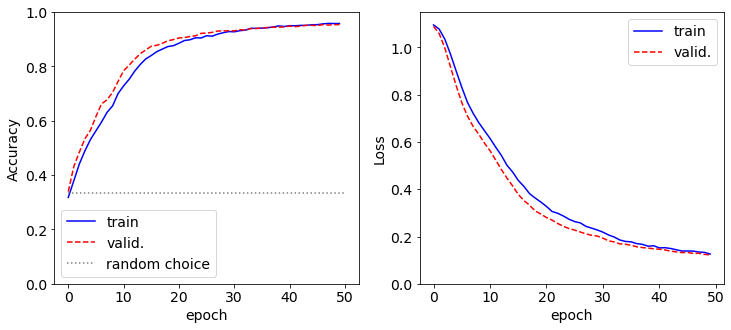

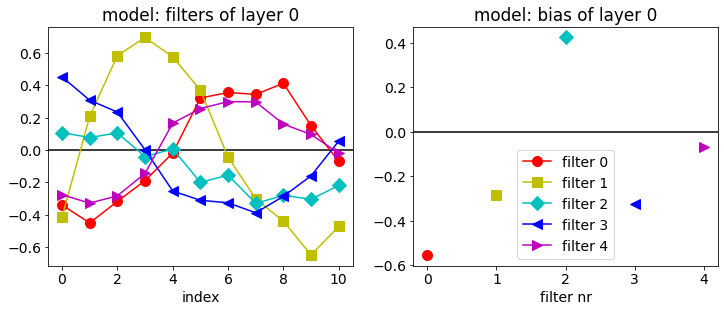

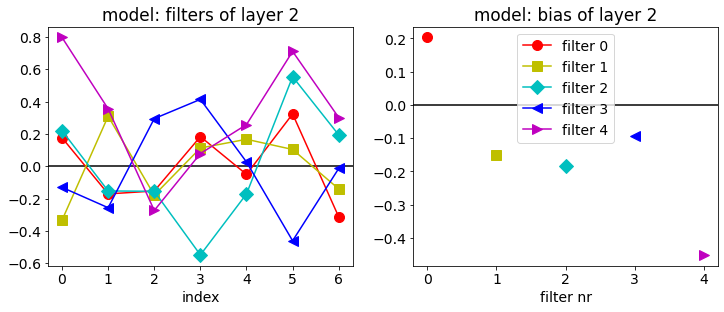

In [7]:
best_params = grid_result.best_params_
best_model = build_model(reg=best_params['reg'], lmb=best_params['lmb'])
print('-----Best Model -----\nFITTING....')
fit = best_model.fit(x_train,y_train,batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_val, y_val),
                verbose=0, shuffle=True)
Show_history(fit)   
Show_weights(best_model,0)
Show_weights(best_model,2)

## Confusion Matrix

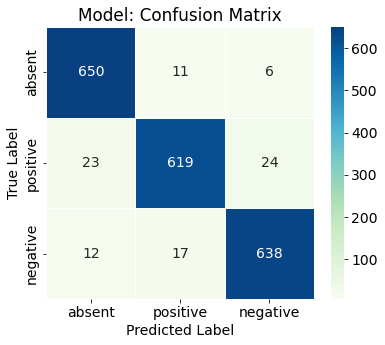

In [8]:
import pandas as pd
from scipy import stats
import seaborn 
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

LABELS = ["absent","positive","negative"]
cmap="GnBu"

def show_confusion_matrix(validations, predictions, label="Model"):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 5))
    seaborn.heatmap(matrix,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d',
                linecolor='white',
                linewidths=1,
                cmap=cmap)
    plt.title(label+': Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_val = best_model.predict(x_val)
# Take the class with the highest probability from the val predictions
max_y_pred_val = np.argmax(y_pred_val, axis=1)
max_y_val = np.argmax(y_val, axis=1)
show_confusion_matrix(max_y_val, max_y_pred_val)